# Baris Engin 24213918
# Ivor D Souza 24177431

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import set_config

In [3]:
data = pd.read_csv('tracks.csv')

Check if there are any missing values in the dataset, as well as the data type for each column.

In [4]:
print("Dataset information:")
data.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        1500 non-null   int64  
 1   duration_ms       1500 non-null   int64  
 2   explicit          1500 non-null   bool   
 3   danceability      1500 non-null   float64
 4   energy            1500 non-null   float64
 5   key               1500 non-null   int64  
 6   loudness          1500 non-null   float64
 7   mode              1500 non-null   int64  
 8   speechiness       1500 non-null   float64
 9   acousticness      1500 non-null   float64
 10  instrumentalness  1500 non-null   float64
 11  liveness          1500 non-null   float64
 12  valence           1500 non-null   float64
 13  tempo             1500 non-null   float64
 14  time_signature    1500 non-null   int64  
 15  track_genre       1500 non-null   object 
dtypes: bool(1), float64(9

Calculate the median of popularity

In [5]:
popularity_median = data['popularity'].median()
print(f"Median of popularity: {popularity_median}")

Median of popularity: 25.0


Create a popularity_binary column where rows with popularity above median are 1 and the rest is 0

In [6]:
data['popularity_binary'] = (data['popularity'] > popularity_median).astype(int)

Prepare the features and target

In [7]:
X = data.drop(['popularity', 'popularity_binary'], axis=1)
y = data['popularity_binary']

Create training set and testing set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Separate categorical and numerical columns

In [9]:
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [10]:
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['explicit', 'track_genre']
Numerical columns: ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


Define numerical and categorical transformers, we use StandardScaler for numerical columns and OneHotEncoder for categorial columns. No missing values so no need to use imputer.

In [11]:
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [12]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

Combine preprocessing steps

In [13]:
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols), ('cat', categorical_transformer, categorical_cols)])

Define a function to evaluate various models

In [39]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Use logistic regressor, random forest, gradient booster and SVM as classification algorithms

1. Logistic regressor

In [16]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=10)),  # Select top 10 features
    ('reduce_dim',  'passthrough'),
    ('classifier', LogisticRegression(random_state=42))
])

set_config(display="diagram")
logreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['explicit',
                                                   'track_genre'])])),
                ('feature_selection', SelectKBest()),
                ('reduce_dim', 'passthrough'),
                ('classifier', LogisticRegression(random_state=42))])

In [25]:
K_OPTIONS = [5, 10, 15]  # Options for SelectKBest
C_OPTIONS = [0.01, 0.1, 1.0, 10.0]  # Regularization strength
N_FEATURES_OPTIONS = [2, 4, 5]  # Number of features/components for dim reduction
SOLVER_OPTIONS = ['liblinear', 'saga']  # Solvers that support both L1 and L2
PENALTY_OPTIONS = ['l1', 'l2']  # Regularization types

param_grid = [
    {
        'feature_selection__k': K_OPTIONS,
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__solver': SOLVER_OPTIONS,
        'classifier__penalty': PENALTY_OPTIONS
    },
    {
        'feature_selection__k': K_OPTIONS,
        'reduce_dim': [KernelPCA(fit_inverse_transform=True)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__solver': SOLVER_OPTIONS,
        'classifier__penalty': PENALTY_OPTIONS
    },
    {
        'feature_selection__k': K_OPTIONS,
        'reduce_dim': [FastICA(max_iter=500)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__solver': SOLVER_OPTIONS,
        'classifier__penalty': PENALTY_OPTIONS
    },
    {
        'feature_selection__k': K_OPTIONS,
        'reduce_dim': [RFE(LinearSVC(penalty='l2', dual=False))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__solver': SOLVER_OPTIONS,
        'classifier__penalty': PENALTY_OPTIONS
    }
]


logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    refit=True
)

print("Training Logistic Regression with Grid Search...")
logreg_grid.fit(X_train, y_train)

print("Best CV score = %0.3f:" % logreg_grid.best_score_)
print("Best parameters: ", logreg_grid.best_params_)

LR_best_params = logreg_grid.best_params_
LR_best_model = logreg_grid.best_estimator_

Training Logistic Regression with Grid Search...


/Users/ivor/Desktop/ul/CS4168 - Data Mining/Lab/dm2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/ivor/Desktop/ul/CS4168 - Data Mining/Lab/dm2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/ivor/Desktop/ul/CS4168 - Data Mining/Lab/dm2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/ivor/Desktop/ul/CS4168 - Data Mining/Lab/dm2/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Best CV score = 0.722:
Best parameters:  {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'feature_selection__k': 10, 'reduce_dim': RFE(estimator=LinearSVC(dual=False)), 'reduce_dim__n_features_to_select': 5}


2. Random Forest

In [26]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reduce_dim',  'passthrough'),
    ('classifier', RandomForestClassifier(random_state=42))
])

set_config(display="diagram")
logreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['explicit',
                                                   'track_genre'])])),
                ('feature_selection', SelectKBest()),
                ('reduce_dim', 'passthrough'),
                ('classifier', LogisticRegression(random_state=42))])

In [27]:
N_FEATURES_OPTIONS = [2, 4, 5]  # Number of features/components for dim reduction
N_ESTIMATORS_OPTIONS = [100, 200]
MAX_DEPTH_OPTIONS = [None, 10, 20]
MIN_SAMPLES_SPLIT_OPTIONS = [2, 5]
MIN_SAMPLES_LEAF_OPTIONS = [1, 2]

rf_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__min_samples_split': MIN_SAMPLES_SPLIT_OPTIONS,
        'classifier__min_samples_leaf': MIN_SAMPLES_LEAF_OPTIONS
    },
    {
        'reduce_dim': [KernelPCA(fit_inverse_transform=True)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__min_samples_split': MIN_SAMPLES_SPLIT_OPTIONS,
        'classifier__min_samples_leaf': MIN_SAMPLES_LEAF_OPTIONS
    },
    {
        'reduce_dim': [FastICA(max_iter=500)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__min_samples_split': MIN_SAMPLES_SPLIT_OPTIONS,
        'classifier__min_samples_leaf': MIN_SAMPLES_LEAF_OPTIONS
    },
    {
        'reduce_dim': [RFE(LinearSVC(penalty='l2', dual=False))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__min_samples_split': MIN_SAMPLES_SPLIT_OPTIONS,
        'classifier__min_samples_leaf': MIN_SAMPLES_LEAF_OPTIONS
    }
]

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    n_jobs=-1,
    refit=True
)

print("Training Random Forest with Grid Search...")
rf_grid.fit(X_train, y_train)

print("Best CV score = %0.3f:" % rf_grid.best_score_)
print("Best parameters: ", rf_grid.best_params_)

RF_best_params = rf_grid.best_params_
RF_best_model = rf_grid.best_estimator_

Training Random Forest with Grid Search...
Best CV score = 0.721:
Best parameters:  {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'reduce_dim': FastICA(max_iter=500), 'reduce_dim__n_components': 4}


3. Gradient Boosting

In [29]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reduce_dim',  'passthrough'),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

set_config(display="diagram")
gb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['explicit',
                                                   'track_genre'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [30]:
N_FEATURES_OPTIONS = [2, 4, 5]  # Number of features/components for dim reduction
N_ESTIMATORS_OPTIONS = [100, 200]
MAX_DEPTH_OPTIONS = [3, 5, 8]
LEARNING_RATE_OPTIONS = [0.01, 0.1, 0.2]
SUBSAMPLE_OPTIONS = [0.8, 1.0]

gb_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__learning_rate': LEARNING_RATE_OPTIONS,
        'classifier__subsample': SUBSAMPLE_OPTIONS
    },
    {
        'reduce_dim': [KernelPCA(fit_inverse_transform=True)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__learning_rate': LEARNING_RATE_OPTIONS,
        'classifier__subsample': SUBSAMPLE_OPTIONS
    },
    {
        'reduce_dim': [FastICA(max_iter=500)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__learning_rate': LEARNING_RATE_OPTIONS,
        'classifier__subsample': SUBSAMPLE_OPTIONS
    },
    {
        'reduce_dim': [RFE(LinearSVC(penalty='l2', dual=False))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__learning_rate': LEARNING_RATE_OPTIONS,
        'classifier__subsample': SUBSAMPLE_OPTIONS
    }
]

gb_grid = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=gb_param_grid,
    cv=5,
    n_jobs=-1,
    refit=True
)

print("Training Gradient Boosting with Grid Search...")
gb_grid.fit(X_train, y_train)

print(f"Best CV score = {gb_grid.best_score_:.3f}")
print(f"Best parameters: {gb_grid.best_params_}")

GB_best_params = gb_grid.best_params_
GB_best_model = gb_grid.best_estimator_

Training Gradient Boosting with Grid Search...
Best CV score = 0.730
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8, 'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 5}


4. SVC

In [31]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reduce_dim', 'passthrough'),  
    ('classifier', SVC(probability=True, random_state=42))
])

set_config(display="diagram")
svm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'time_signature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['explicit',
                                                   'track_genre'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier', SVC(probability=True, random_state=42))])

In [32]:
N_FEATURES_OPTIONS = [2, 4, 5]  # Number of features/components for dim reduction
C_OPTIONS = [0.1, 1.0, 10.0, 100.0]  # Regularization parameter
GAMMA_OPTIONS = ['scale', 'auto', 0.1, 0.01]  # Kernel coefficient
KERNEL_OPTIONS = ['rbf', 'poly', 'sigmoid']  # Kernel types

svm_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS,
        'classifier__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [KernelPCA(fit_inverse_transform=True)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS,
        'classifier__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [FastICA(max_iter=500)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS,
        'classifier__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [RFE(LinearSVC(penalty='l2', dual=False))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS,
        'classifier__kernel': KERNEL_OPTIONS
    }
]

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    n_jobs=-1,
    refit=True
)

print("Training SVM with Grid Search...")
svm_grid.fit(X_train, y_train)

print(f"Best CV score = {svm_grid.best_score_:.3f}")
print(f"Best parameters: {svm_grid.best_params_}")

SVM_best_params = svm_grid.best_params_
SVM_best_model = svm_grid.best_estimator_

Training SVM with Grid Search...
Best CV score = 0.724
Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'reduce_dim': RFE(estimator=LinearSVC(dual=False)), 'reduce_dim__n_features_to_select': 5}


### Evaluate models

Compare models by their resulting accuracy, precision, recall, f1-score and AUC score

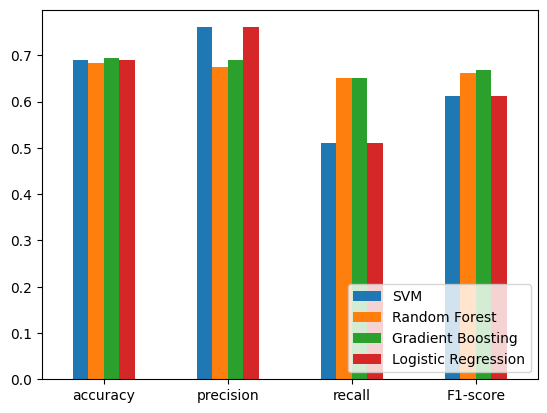

In [38]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])   
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
GB_accuracy, GB_precision, GB_recall, GB_f1_score, GB_tpr, GB_auc = evaluate_model(X_test, y_test, GB_best_model)
GB_metrics = np.array([GB_accuracy, GB_precision, GB_recall, GB_f1_score])
LR_accuracy, LR_precision, LR_recall, LR_f1_score, LR_tpr, LR_auc = evaluate_model(X_test, y_test, LR_best_model)
LR_metrics = np.array([LR_accuracy, LR_precision, LR_recall, LR_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'Gradient Boosting': GB_metrics, 'Logistic Regression': LR_metrics},
                          index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Compare models by their resulting accuracy, precision, recall, f1-score and AUC score

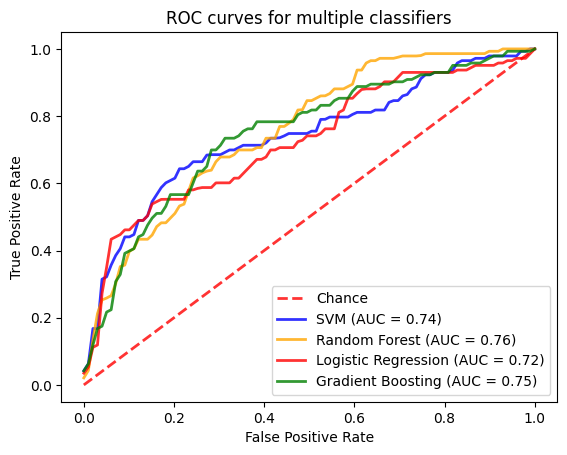

In [40]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, LR_tpr[0,:], lw=2, color='red', label='Logistic Regression (AUC = %0.2f)' % (LR_auc), alpha=0.8)
plt.plot(mean_fpr, GB_tpr[0,:], lw=2, color='green', label='Gradient Boosting (AUC = %0.2f)' % (GB_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation and Selection

Let's analyze the performance metrics of all the classification models to determine the best model for predicting song popularity:

### Performance Metrics Comparison

| Metric | SVM | Random Forest | Gradient Boosting | Logistic Regression |
|--------|-----|--------------|-------------------|---------------------|
| Accuracy | 0.690 | 0.683 | **0.693** | 0.690 |
| Precision | **0.760** | 0.674 | 0.689 | **0.760** |
| Recall | 0.510 | **0.650** | **0.650** | 0.510 |
| F1-score | 0.611 | 0.662 | **0.669** | 0.611 |
| AUC | 0.739 | **0.756** | **0.746** | 0.724 |

### Best Model Selection

Based on the comprehensive evaluation of metrics, the **Gradient Boosting** model appears to be the best choice for our Spotify popularity prediction task for the following reasons:

1. **Balanced performance**: It achieves the highest accuracy (0.693) and F1-score (0.669) among all models, indicating good overall performance.

2. **Strong recall**: With a recall of 0.650, it significantly outperforms the SVM and Logistic Regression models in identifying popular songs, reducing false negatives.

3. **Good AUC score**: Its AUC of 0.746 is competitive, close to the best performer (Random Forest at 0.756), showing strong discriminatory power across different thresholds.

4. **Reasonable precision**: While its precision (0.689) is lower than SVM and Logistic Regression (both 0.760), the difference is acceptable given the substantial gains in recall.

The Random Forest model is a close second, with similar recall and better AUC, but slightly lower accuracy and F1-score. The SVM and Logistic Regression models have identical performance with high precision but poor recall, suggesting they are too conservative in predicting popular songs.